<a href="https://colab.research.google.com/github/imdeepmind/CrowdCounter/blob/master/Crowd_Counter_(Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Getting the dataset into proper place
!mkdir data
!cp '/content/drive/My Drive/datasets/dataset.zip' ./
!unzip -qq dataset.zip -d ./data/
!rm dataset.zip

In [2]:
# Script to generate the processed.csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

labels = pd.read_csv('data/labels.csv')

preprocessed_labels = []
preprocessed_images = []

images = os.listdir("/content/data/frames/frames")

for (id, count) in labels.values:
  preprocessed_labels.append(count)
  preprocessed_images.append(images[id-1])

df = pd.DataFrame(columns=['image', 'count'])
df['image'] = preprocessed_images
df['count'] = preprocessed_labels

df.head()

df.to_csv('./data/processed.csv', index=False)

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam

In [15]:
# Reading data
data = pd.read_csv("./data/processed.csv")

data.head()

,image,count
0,seq_001106.jpg,35
1,seq_001433.jpg,41
2,seq_000460.jpg,41
3,seq_000295.jpg,44
4,seq_001890.jpg,41


In [16]:
train, test = train_test_split(data, test_size=0.1, random_state=1969)

train.head()

,image,count
261,seq_000691.jpg,18
962,seq_000568.jpg,31
592,seq_000271.jpg,25
884,seq_001953.jpg,25
84,seq_000805.jpg,31


In [42]:
train_generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255.)


In [43]:
train_data = train_generator.flow_from_dataframe(train, 
                                                 directory='./data/frames/frames/', 
                                                 x_col='image', 
                                                 y_col='count', 
                                                 target_size=(640, 480),
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True)

test_data = test_generator.flow_from_dataframe(test, 
                                                 directory='./data/frames/frames/', 
                                                 x_col='image', 
                                                 y_col='count', 
                                                 target_size=(640, 480),
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 batch_size=32,
                                                 shuffle=True)


Found 1800 validated image filenames.
Found 200 validated image filenames.


In [48]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (640,480,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1))

In [49]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [50]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 640, 480, 32)      2432      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 320, 240, 32)      0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 320, 240, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 320, 240, 64)      51264     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 160, 120, 64)      0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 160, 120, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 160, 120, 128)    

In [51]:
history = model.fit(train_data, 
          steps_per_epoch=1800//32,
          validation_data=test_data,
          validation_steps=200//32,
          epochs=3)

Epoch 1/3
56/56 [==============================] - 171s 3s/step - loss: 1498.4061 - mae: 15.5867 - val_loss: 231.8284 - val_mae: 13.6407
Epoch 2/3
56/56 [==============================] - 173s 3s/step - loss: 73.1987 - mae: 6.8116 - val_loss: 234.9359 - val_mae: 13.7532
Epoch 3/3
56/56 [==============================] - 171s 3s/step - loss: 78.8587 - mae: 7.1139 - val_loss: 195.3768 - val_mae: 12.2688


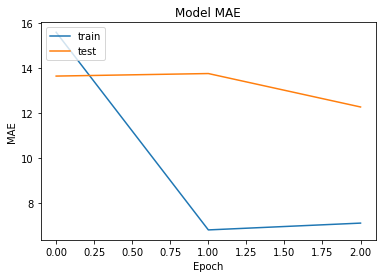

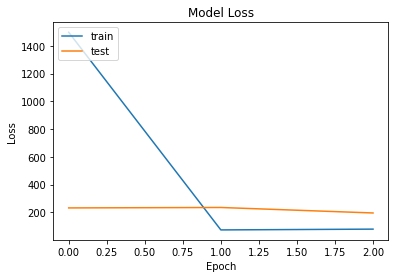

In [52]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()